##### Author: Matthew W. Boyce, PhD, 
##### Email: boyce.matthew@epa.gov

##### Version: 2.0 10-07-2020

##### Description:  
- This script compares the metabolite output for a number of metabolite prediction softwares: OECD Toolbox, Nexus Meteor, TIMES, SyGMA, CTS and Biotransformer. The script is scalable and and can be expanded to include more or less metabolite software tools by changing the dfList variable, but will require additional functions in the Model_Comp script to pull data from specific datasets.

##### Notes: This script uses os, pandas, numpy, matplotlib, rdkit, scipy, and Model_Comp

##### Potential issues: *None known*





#### Updates:
- Additional processing and analysis performed by Grace Patlewicz

In [50]:
import os as os
import pandas as pd
import numpy as np
import sygma
import matplotlib.pyplot as plt

import matplotlib.image as mpimg


from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

from rdkit.Chem.Draw import MolsToGridImage
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist, squareform, cdist


In [3]:
TOP = os.getcwd().replace('notebooks', '')

In [4]:
raw_dat_dir = TOP + 'data/raw/'
processed_dat_dir = TOP + 'data/processed/'
interim_dat_dir = TOP + 'data/interim/'
figures_dir = TOP + 'reports/figures/'
external_dir = TOP + 'data/external/'


In [13]:
import sys

sys.path.append(TOP + 'src/data/')

from model_comp import *

## Table Of Contents:
* [Read and Clean](#first-bullet)
* [Prediction Counts Per Model and Parent](#second-bullet)
* [Summarized Data and Performance Evaluation](#third-bullet)
* [Performance Evaluation](#fourth-bullet)
* [Chemical Groupings](#third-bullet)
* [Grouped Performance](#third-bullet)

## Read and Clean <a class="anchor" id="first-bullet"></a>

#### Create a list of the metabolism in silico tools. This can be adjusted depending on the selected tools.

In [6]:
modelList = ['ToolBox', 'Meteor','BioTransformer','TIMES_InVivo','TIMES_InVitro', 'SyGMa', 'CTS'] 

#### Import the original csv file containing the ExpoCast substances downloaded from the EPA CompTox Chemicals dashboard
#### Generate two dictionaries for the normal and qsar ready InChI keys to link to DTXSIDs

In [7]:
DSSToxList = pd.read_csv(processed_dat_dir+"CompToxList.csv", header = 0)
DSSToxList = DSSToxList.rename(columns={'INCHIKEY':'Parent_INCHIKEY'})
DSSToxList['QSAR_READY_INCHIKEY'] = SMILES_to_InchiKey(DSSToxList['QSAR_READY_SMILES'],stereoisomer = False)
Norm_DTXSID_dict = dict(zip(DSSToxList['Parent_INCHIKEY'],DSSToxList['DTXSID']))
QSAR_DTXSID_dict = dict(zip(DSSToxList['QSAR_READY_INCHIKEY'],DSSToxList['DTXSID']))

In [8]:
DSSToxList.head()

,INPUT,FOUND_BY,DTXSID,PREFERRED_NAME,CASRN,Parent_INCHIKEY,SMILES,QSAR_READY_SMILES,QSAR_READY_INCHIKEY
0,DTXSID0044151,DSSTox_Substance_Id,DTXSID0044151,"3,5-Dinitroaniline",618-87-1,MPBZUKLDHPOCLS-UHFFFAOYSA-N,NC1=CC(=CC(=C1)[N+]([O-])=O)[N+]([O-])=O,NC1=CC(=CC(=C1)[N+]([O-])=O)[N+]([O-])=O,MPBZUKLDHPOCLS-UHFFFAOYSA-N
1,DTXSID6025725,DSSTox_Substance_Id,DTXSID6025725,3-Nitroaniline,99-09-2,XJCVRTZCHMZPBD-UHFFFAOYSA-N,NC1=CC(=CC=C1)[N+]([O-])=O,NC1=CC(=CC=C1)[N+]([O-])=O,XJCVRTZCHMZPBD-UHFFFAOYSA-N
2,DTXSID8031077,DSSTox_Substance_Id,DTXSID8031077,Curcumin,458-37-7,VFLDPWHFBUODDF-FCXRPNKRSA-N,COC1=CC(\C=C\C(=O)CC(=O)\C=C\C2=CC=C(O)C(OC)=C...,COC1=CC(C=CC(=O)CC(=O)C=CC2=CC(OC)=C(O)C=C2)=C...,VFLDPWHFBUODDF-UHFFFAOYSA-N
3,DTXSID1025726,DSSTox_Substance_Id,DTXSID1025726,2-Nitroaniline,88-74-4,DPJCXCZTLWNFOH-UHFFFAOYSA-N,NC1=CC=CC=C1[N+]([O-])=O,NC1=CC=CC=C1[N+]([O-])=O,DPJCXCZTLWNFOH-UHFFFAOYSA-N
4,DTXSID4025791,DSSTox_Substance_Id,DTXSID4025791,2-Nitrotoluene,88-72-2,PLAZTCDQAHEYBI-UHFFFAOYSA-N,CC1=CC=CC=C1[N+]([O-])=O,CC1=CC=CC=C1[N+]([O-])=O,PLAZTCDQAHEYBI-UHFFFAOYSA-N


#### Use model_comp.py functions to import and process raw data generated by each of the metabolite in silico tools 

In [17]:
toolBoxDF = ToolBox_cleanup(processed_dat_dir+'Toolbox_Report.csv', QSAR_DTXSID_dict)
meteorDF = Meteor_cleanup(processed_dat_dir+'Meteor_Report.csv')
bioTransformerDF = BioTransformer_cleanup(processed_dat_dir+'BioTransformer_Report.csv', Norm_DTXSID_dict)
times_inVivoDF = TIMES_cleanup(processed_dat_dir+'ivTIMES_010621.csv', 'TIMES_InVivo')
times_inVitroDF = TIMES_cleanup(processed_dat_dir+'ivtTIMES_010621.csv', 'TIMES_InVitro')
ctsDF = CTS_cleanup(processed_dat_dir+'CTS_All_Report.csv', QSAR_DTXSID_dict)


In [18]:
def TIMES_cleanup (file, Model_Module):
    """Cleans data genrated by Oasis TIMES and returns a dataframe witht he DTXSID of the parent compound and InChI key of each metabolite"""
    """The Model_Module argument should be a string to designate the model used for metabolism (e.g., TIMES_RatLiver S9, TIMES_RatInVivo"""
    df = pd.read_csv(file, delimiter = ",")    
    df.rename(columns={'Chem. Name':'DTXSID'},inplace = True) 
    df = df[['DTXSID', 'Smiles']]
    df = df[1:]
    df = df[:-2]                                                                      
    df[Model_Module] = 1                                                            #Adds Times_(Model_Module) to designate model generating metabolite
    df['DTXSID'].replace({' ': np.NaN}, inplace = True)                            #Cleans DTXSID to list NaN in empty rows
    df['Metabolite_INCHIKEY'] = np.NaN                                             #Initialized column for metabolite InChI key
    metabList = df.Smiles[df['DTXSID'].isnull()]                                    #Establishes boolean list to desgiante indecies with metabolite smiles
    df['Metabolite_INCHIKEY'] = SMILES_to_InchiKey(metabList)                       #Converts metabolie SMILES to InChI keys
    df['DTXSID'] = df['DTXSID'].fillna(method = 'ffill')                            #Fills empty spaces with DTXSID, empty spaces are filled with the preceeding DTXSID
    df = df[df['Metabolite_INCHIKEY'].notnull()]                                    #Removes any all parent entries, whcih are represented as nulls in the metabolite INCHIKEY list
    df = df.drop_duplicates()  
    df[['Formula','[M+H]']] = SMILES_to_MW(df.Smiles)
    df['Clean_SMILES'] = clean_SMILES(df['Smiles'])
    return df[['DTXSID','Metabolite_INCHIKEY','Clean_SMILES','Formula','[M+H]', Model_Module]];


In [20]:
times_inVitroDF = TIMES_cleanup(processed_dat_dir+'ivtTIMES_010621.csv', 'TIMES_InVitro')

#### Generate SyGMa metabolites in notebook and using function to return appropriately formatted DF

In [21]:

sygmaDF = gen_sygma_metabolites_DF(DSSToxList['SMILES'], Norm_DTXSID_dict, pathways = [[sygma.ruleset['phase1'], 2],[sygma.ruleset['phase2'],1]])



#### Import reported metabolites from the file exported by ChemReg and a file relating InChI keys to DTXSIDs

In [22]:

litDF = genLiteratureDF(processed_dat_dir+'ExpocastMetab_CompiledLit.csv', processed_dat_dir+'DTXSID_Markush_Final.csv')

In [23]:
tb = toolBoxDF[toolBoxDF['DTXSID'] == 'DTXSID0044151']['Clean_SMILES'].tolist()

In [24]:
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Draw

In [25]:
toolBoxDF[toolBoxDF['DTXSID'] == 'DTXSID0044151']

,DTXSID,Metabolite_INCHIKEY,Clean_SMILES,ToolBox
1,DTXSID0044151,RPHKINMPYFJSCF-UHFFFAOYSA-N,Nc1cc(N)cc(N)c1,1
2,DTXSID0044151,DFWXYHZQNLIBLY-UHFFFAOYSA-N,Nc1cc(N)cc([N+](=O)[O-])c1,1
3,DTXSID0044151,VUCKZBYGRGKCCQ-UHFFFAOYSA-N,Nc1cc(NO)cc([N+](=O)[O-])c1,1
4,DTXSID0044151,WSIDAANKKVDFNY-UHFFFAOYSA-N,O=[N+]([O-])c1cc(NO)cc([N+](=O)[O-])c1,1


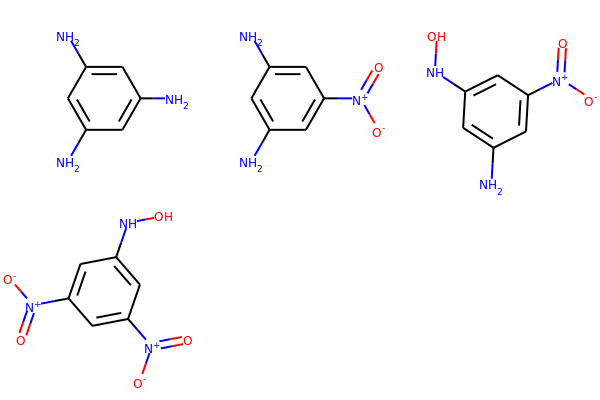

In [26]:
MolsToGridImage([Chem.MolFromSmiles(e) for e in tb])


In [27]:
meteorDF.head()

,DTXSID,Metabolite_INCHIKEY,Clean_SMILES,Meteor
1,DTXSID0020151,QTBSBXVTEAMEQO-UHFFFAOYSA-N,CC(=O)O,1
2,DTXSID0020151,WVDDGKGOMKODPV-UHFFFAOYSA-N,OCc1ccccc1,1
3,DTXSID0020151,WPYMKLBDIGXBTP-UHFFFAOYSA-N,O=C(O)c1ccccc1,1
4,DTXSID0020151,QIAFMBKCNZACKA-UHFFFAOYSA-N,O=C(O)CNC(=O)c1ccccc1,1
6,DTXSID0020151,BJUXDERNWYKSIQ-UHFFFAOYSA-N,CC(=O)NC(CSCc1ccccc1)C(=O)O,1


In [28]:
bioTransformerDF.head()

,DTXSID,Metabolite_INCHIKEY,Clean_SMILES,BioTransformer
0,DTXSID0044151,QXYMVUZOGFVPGH-UHFFFAOYSA-N,NC1=C(O)C([N+](=O)[O-])=CC([N+](=O)[O-])=C1,1
2,DTXSID0044151,TTXPIURLJOPGTE-UHFFFAOYSA-N,NC1=CC([N+](=O)[O-])=C(O)C([N+](=O)[O-])=C1,1
3,DTXSID0044151,WSIDAANKKVDFNY-UHFFFAOYSA-N,O=[N+]([O-])C1=CC(NO)=CC([N+](=O)[O-])=C1,1
6,DTXSID0044151,OQLXBGXMCLUSAC-UHFFFAOYSA-N,NC1=C(O)C([N+](=O)[O-])=CC([N+](=O)[O-])=C1O,1
8,DTXSID0044151,ZVFXOCHWBWRBDV-UHFFFAOYSA-N,NC1=CC([N+](=O)[O-])=C(O)C([N+](=O)[O-])=C1O,1


In [36]:
times_inVivoDF = times_inVivoDF[['DTXSID', 'Metabolite_INCHIKEY', 'Clean_SMILES', 'TIMES_InVivo']]

In [37]:
times_inVitroDF = times_inVitroDF[['DTXSID', 'Metabolite_INCHIKEY', 'Clean_SMILES', 'TIMES_InVitro']]

In [31]:
ctsDF.head()

,DTXSID,Metabolite_INCHIKEY,Clean_SMILES,CTS
1,DTXSID0044151,DFWXYHZQNLIBLY-UHFFFAOYSA-N,Nc1cc(N)cc([N+](=O)[O-])c1,1
2,DTXSID0044151,RPHKINMPYFJSCF-UHFFFAOYSA-N,Nc1cc(N)cc(N)c1,1
3,DTXSID0044151,SUYLOMATYCPVFT-UHFFFAOYSA-N,Nc1cc(N)c(O)c(N)c1,1
4,DTXSID0044151,WFNVGXBEWXBZPL-UHFFFAOYSA-N,Nc1cc(N)cc(O)c1,1
5,DTXSID0044151,VKFBRTZWQOUOSP-UHFFFAOYSA-N,Nc1cc(N)cc(NO)c1,1


In [32]:
sygmaDF.head()

,DTXSID,Metabolite_INCHIKEY,Clean_SMILES,SyGMa
1,DTXSID0044151,ZXERTWPNZJETAC-UHFFFAOYSA-N,CC(=O)Nc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1,1
2,DTXSID0044151,TTXPIURLJOPGTE-UHFFFAOYSA-N,Nc1cc([N+](=O)[O-])c(O)c([N+](=O)[O-])c1,1
3,DTXSID0044151,QXYMVUZOGFVPGH-UHFFFAOYSA-N,Nc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1O,1
4,DTXSID0044151,DFWXYHZQNLIBLY-UHFFFAOYSA-N,Nc1cc(N)cc([N+](=O)[O-])c1,1
5,DTXSID0044151,DJJDJEGEEBJYIT-UHFFFAOYSA-N,CC(=O)Nc1cc([N+](=O)[O-])c(O)c([N+](=O)[O-])c1,1


In [70]:
litDF[litDF['DTXSID'] == 'DTXSID9020376']

,DTXSID,Metabolite_INCHIKEY,Reported,Metabolite DTXSID,Markush
271,DTXSID9020376,HXEMCBBMCIVBCX-UHFFFAOYSA-N,1,DTXSID901026604,True
272,DTXSID9020376,DLMCJBXKWMGJFI-UHFFFAOYSA-N,1,DTXSID901026604,True
273,DTXSID9020376,TYWAAVDKOMVWQR-UHFFFAOYSA-N,1,DTXSID901026604,True
274,DTXSID9020376,SDUQEHSQUYKVEV-UHFFFAOYSA-N,1,DTXSID901026604,True
275,DTXSID9020376,YASRWMFYKOLLDF-UHFFFAOYSA-N,1,DTXSID901026604,True
...,...,...,...,...,...
810,DTXSID9020376,BSDWZURHBLFYCR-UHFFFAOYSA-N,1,DTXSID501026602,True
811,DTXSID9020376,NSDATEXVZHLGGR-UHFFFAOYSA-N,1,DTXSID501026602,True
812,DTXSID9020376,HVDAIOBTIADXRD-UHFFFAOYSA-N,1,DTXSID501026602,True
813,DTXSID9020376,XOCGQTAUPLITKJ-UHFFFAOYSA-N,1,DTXSID501026602,True


#### Generate list of the dataframes containing the cleaned data then aggregate the data into a single dataframe: agg_Data
#### Note: In the aggregate data, each software has its own column with a 1 or 0, which indicates that the software predicted or did not predict that metabolite

In [38]:

dfList = [toolBoxDF, meteorDF, bioTransformerDF,times_inVivoDF, times_inVitroDF, sygmaDF, ctsDF, litDF]
agg_Data = aggregate_DFs(dfList)

agg_Data['Metabolite DTXSID'].replace(0, 'NA', inplace = True)
agg_Data['Markush'].replace(0, False, inplace = True)

agg_Data.sort_values(by='DTXSID')

,DTXSID,Metabolite_INCHIKEY,ToolBox,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Reported,Metabolite DTXSID,Markush
2995,DTXSID0020151,ZENOXNGFMSCLLL-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NA,False
3047,DTXSID0020151,JKVTYDWBQZINOG-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NA,False
3046,DTXSID0020151,DJXKLNTTXTZFOU-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NA,False
3045,DTXSID0020151,HQOQYSHOHJLNDC-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NA,False
3044,DTXSID0020151,IHFPLGRHJDIZLM-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NA,False
...,...,...,...,...,...,...,...,...,...,...,...,...
6876,DTXSID9047251,UISIXNZJPIKOEN-HLACATRISA-N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DTXSID701025036,False
6877,DTXSID9047251,MTFDBOXMNZOZNL-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DTXSID401025037,False
6878,DTXSID9047251,UERIPGWBODTLES-XPORZQOISA-N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DTXSID101025038,False
1544,DTXSID9047251,PMMQQTIGSUZPMD-JRUYECLLSA-N,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NA,False


In [39]:
rowSum = agg_Data[['ToolBox','Meteor','BioTransformer','TIMES_InVitro','TIMES_InVivo','SyGMa','CTS', 'Reported']].apply(lambda x: sum(x), axis = 1)
uniqueCount = sum(rowSum > 0)
uniqueCount

7521

In [40]:
agg_Data[agg_Data['DTXSID']== 'DTXSID0044151']['ToolBox'].sum()

4.0

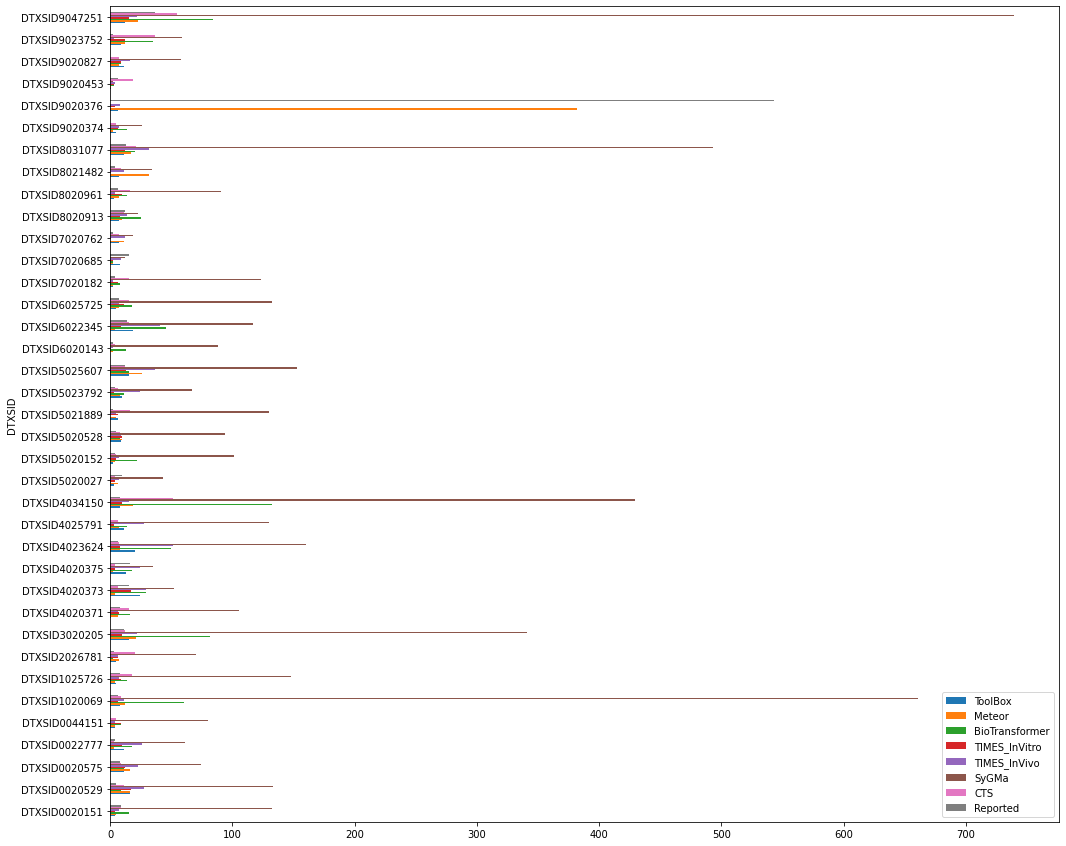

In [42]:

agg_Data.groupby('DTXSID').agg({'ToolBox': 'sum', 'Meteor' :'sum','BioTransformer': 'sum','TIMES_InVitro':'sum','TIMES_InVivo':'sum','SyGMa':'sum','CTS':'sum', 'Reported':'sum'}).plot.barh(figsize = (17,15))

In [43]:
agg_Data.groupby('DTXSID').agg({'ToolBox': 'sum', 'Meteor' :'sum','BioTransformer': 'sum','TIMES_InVitro':'sum','TIMES_InVivo':'sum','SyGMa':'sum','CTS':'sum', 'Reported':'sum'}).describe()

,ToolBox,Meteor,BioTransformer,TIMES_InVitro,TIMES_InVivo,SyGMa,CTS,Reported
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,8.486486,19.297297,22.351351,7.648649,15.405405,140.945946,12.756757,21.918919
std,5.600702,61.732337,27.775105,4.296098,12.216700,171.918415,12.037916,88.302944
min,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000
25%,5.000000,4.000000,8.000000,4.000000,7.000000,52.000000,6.000000,4.000000
50%,8.000000,7.000000,14.000000,8.000000,11.000000,91.000000,9.000000,6.000000
75%,11.000000,12.000000,22.000000,10.000000,24.000000,132.000000,15.000000,11.000000
max,24.000000,382.000000,132.000000,17.000000,51.000000,739.000000,55.000000,543.000000


In [44]:
import seaborn as sns

In [45]:
grpby = agg_Data.groupby('DTXSID').agg({'ToolBox': 'sum', 'Meteor' :'sum','BioTransformer': 'sum','TIMES_InVitro':'sum','TIMES_InVivo':'sum','SyGMa':'sum','CTS':'sum', 'Reported':'sum'})

In [46]:
grpby.describe()

,ToolBox,Meteor,BioTransformer,TIMES_InVitro,TIMES_InVivo,SyGMa,CTS,Reported
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,8.486486,19.297297,22.351351,7.648649,15.405405,140.945946,12.756757,21.918919
std,5.600702,61.732337,27.775105,4.296098,12.216700,171.918415,12.037916,88.302944
min,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000
25%,5.000000,4.000000,8.000000,4.000000,7.000000,52.000000,6.000000,4.000000
50%,8.000000,7.000000,14.000000,8.000000,11.000000,91.000000,9.000000,6.000000
75%,11.000000,12.000000,22.000000,10.000000,24.000000,132.000000,15.000000,11.000000
max,24.000000,382.000000,132.000000,17.000000,51.000000,739.000000,55.000000,543.000000


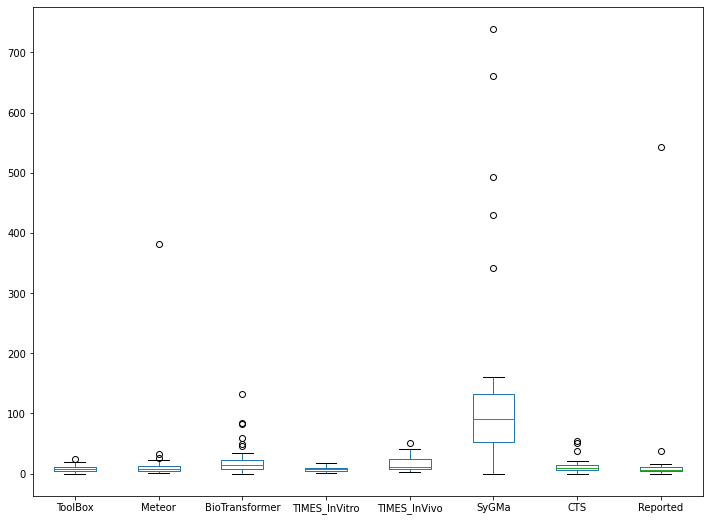

In [51]:
grpby[grpby.columns.tolist()].plot(kind = 'box', figsize = (12,9))

plt.savefig(figures_dir+'BoxPlot_Metabolite_count.png', dpi = 300)

In [52]:
for chem in set(agg_Data['DTXSID']):
    chemFilter = agg_Data['DTXSID'] == chem
    predictedFilter = rowSum > 0
    sumPredicted = sum(chemFilter & predictedFilter)
    print(chem, sumPredicted)

DTXSID1020069 732
DTXSID0020575 99
DTXSID5021889 140
DTXSID8031077 551
DTXSID0020529 153
DTXSID0022777 99
DTXSID4020371 128
DTXSID0020151 153
DTXSID1025726 171
DTXSID9020376 919
DTXSID5025607 183
DTXSID6025725 156
DTXSID5020528 107
DTXSID5020027 63
DTXSID5023792 82
DTXSID8020913 63
DTXSID7020762 34
DTXSID7020685 40
DTXSID9047251 910
DTXSID7020182 137
DTXSID2026781 85
DTXSID4034150 574
DTXSID8020961 113
DTXSID9020827 74
DTXSID3020205 416
DTXSID6020143 98
DTXSID9020453 31
DTXSID9023752 124
DTXSID5020152 117
DTXSID0044151 85
DTXSID4023624 250
DTXSID4020373 113
DTXSID4020375 85
DTXSID9020374 41
DTXSID4025791 143
DTXSID6022345 199
DTXSID8021482 53


In [53]:
for chem in set(agg_Data['DTXSID']):
    chemFilter = agg_Data['DTXSID'] == chem
    predictedFilter = agg_Data['Reported'] > 0
    sumMarkush = len(set(agg_Data['Metabolite DTXSID'][chemFilter & predictedFilter]))
    sumDiscrete = len(set(agg_Data['Metabolite_INCHIKEY'][chemFilter & predictedFilter]))
    print(chem, sumDiscrete, sumMarkush)

DTXSID1020069 6 6
DTXSID0020575 8 8
DTXSID5021889 2 2
DTXSID8031077 13 13
DTXSID0020529 5 5
DTXSID0022777 4 4
DTXSID4020371 8 8
DTXSID0020151 9 9
DTXSID1025726 8 8
DTXSID9020376 543 7
DTXSID5025607 12 12
DTXSID6025725 7 7
DTXSID5020528 5 5
DTXSID5020027 10 10
DTXSID5023792 4 4
DTXSID8020913 12 11
DTXSID7020762 2 2
DTXSID7020685 15 10
DTXSID9047251 37 18
DTXSID7020182 4 4
DTXSID2026781 3 3
DTXSID4034150 8 7
DTXSID8020961 6 6
DTXSID9020827 0 0
DTXSID3020205 11 11
DTXSID6020143 2 2
DTXSID9020453 6 6
DTXSID9023752 2 2
DTXSID5020152 4 4
DTXSID0044151 0 0
DTXSID4023624 6 6
DTXSID4020373 15 12
DTXSID4020375 16 13
DTXSID9020374 0 0
DTXSID4025791 0 0
DTXSID6022345 14 14
DTXSID8021482 4 4


In [54]:
agg_Data[(agg_Data['DTXSID'] == 'DTXSID4020373') & (agg_Data['Reported'] == 1)]

,DTXSID,Metabolite_INCHIKEY,ToolBox,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Reported,Metabolite DTXSID,Markush
221,DTXSID4020373,LNKQQZFLNUVWQQ-UHFFFAOYSA-N,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,DTXSID6073940,False
223,DTXSID4020373,PLAJRWVPXJKVML-UHFFFAOYSA-N,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,DTXSID50171173,False
224,DTXSID4020373,YIOCIFXUGBYCJR-UHFFFAOYSA-N,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,DTXSID3040699,False
226,DTXSID4020373,ZVIDYKRNLNAXFT-UHFFFAOYSA-N,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,DTXSID5041308,False
237,DTXSID4020373,YOLURZVIWIXYJT-UHFFFAOYSA-N,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,DTXSID901000292,False
238,DTXSID4020373,LXFMMUDXRIMBHN-UHFFFAOYSA-N,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,DTXSID80178554,False
6138,DTXSID4020373,UCNVFOCBFJOQAL-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,DTXSID9020374,False
6960,DTXSID4020373,AHJKRLASYNVKDZ-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DTXSID4020373,False
6961,DTXSID4020373,YAYNSRHGXUZDII-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DTXSID601026017,False
6962,DTXSID4020373,PZQUTPXIDGQKFZ-RXQGYGPJNA-N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DTXSID301026018,True


In [55]:
set(agg_Data['Metabolite DTXSID'][chemFilter & predictedFilter])

{'DTXSID0021206', 'DTXSID0021628', 'DTXSID8021482', 'DTXSID8051590'}

In [56]:
DTXSID_Metab_pairings = list(zip(agg_Data['DTXSID'],agg_Data['Metabolite_INCHIKEY']))

##Returns values that are duplicated in the list of DTXSID_Metab_Pairings
[(i,DTXSID_Metab_pairings.index(DTXSID_Metab_pairings[i]), DTXSID_Metab_pairings[i]) for i in range(len(DTXSID_Metab_pairings)) if not i == DTXSID_Metab_pairings.index(DTXSID_Metab_pairings[i])]

[]

In [57]:
modelList2 = ['ToolBox', 'Meteor','BioTransformer','TIMES_InVivo','TIMES_InVitro', 'SyGMa', 'CTS', 'Reported'] 

## Prediction Counts Per Model and Parent <a class="anchor" id="second-bullet"></a>

In [58]:
# Model comparison for each parent compound

#Generate new dataframe to make comparison and assign DTXSIDs based on csv output from CompTox and takes the sum of metabolites generates
#for each DTXSID

metab_Comp = pd.DataFrame(data = None, columns = ['DTXSID','Metab_Count']+ modelList2)
metab_Comp['DTXSID'] = DSSToxList['INPUT']
metab_Comp['Metab_Count'] = [agg_Data[agg_Data['DTXSID']==x].shape[0] for x in metab_Comp['DTXSID']]

#Returns the number of metabolites predicted by each software for each parent DTXSID
for model in modelList2:
    metab_Comp[model] = [agg_Data[(agg_Data['DTXSID']==DTXSID)&(agg_Data[model]==1)].shape[0] for DTXSID in metab_Comp['DTXSID']]
    
metab_Comp.head(10)

,DTXSID,Metab_Count,ToolBox,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Reported
0,DTXSID0044151,85,4,4,9,4,9,80,5,0
1,DTXSID6025725,156,5,7,18,7,11,132,15,7
2,DTXSID8031077,551,11,17,20,32,12,493,21,13
3,DTXSID1025726,171,5,4,14,7,9,148,18,8
4,DTXSID4025791,143,11,7,14,28,3,130,6,0
5,DTXSID5023792,82,10,8,11,24,3,67,6,4
6,DTXSID8020961,113,3,7,14,4,10,91,16,6
7,DTXSID9020827,74,11,7,9,16,9,58,7,0
8,DTXSID0020151,153,4,5,15,7,4,132,9,9
9,DTXSID1020069,732,8,12,60,11,6,661,9,6


In [201]:
#metab_Comp

In [63]:
metab_Comp.to_csv(interim_dat_dir+'Metabolism_Comparison.csv')

In [67]:
metabcomp = metab_Comp.merge(DSSToxList, on = 'DTXSID', how = 'left')

In [80]:
metabcomp['ToolBox'].sum()

314

In [60]:
#uses the metab_Comp dataframe to generate a dataframe that summarized the percent of total metabolites generated by each software for each parent compound
metab_Comp_Percent = metab_Comp.copy()
for model in modelList2:
    metab_Comp_Percent[model] = round([agg_Data[(agg_Data['DTXSID']==DTXSID)&(agg_Data[model]==1)].shape[0] 
                         for DTXSID in metab_Comp['DTXSID']]/metab_Comp['Metab_Count']*100,2)
    
metab_Comp_Percent.head(10)

,DTXSID,Metab_Count,ToolBox,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Reported
0,DTXSID0044151,85,4.71,4.71,10.59,4.71,10.59,94.12,5.88,0.00
1,DTXSID6025725,156,3.21,4.49,11.54,4.49,7.05,84.62,9.62,4.49
2,DTXSID8031077,551,2.00,3.09,3.63,5.81,2.18,89.47,3.81,2.36
3,DTXSID1025726,171,2.92,2.34,8.19,4.09,5.26,86.55,10.53,4.68
4,DTXSID4025791,143,7.69,4.90,9.79,19.58,2.10,90.91,4.20,0.00
5,DTXSID5023792,82,12.20,9.76,13.41,29.27,3.66,81.71,7.32,4.88
6,DTXSID8020961,113,2.65,6.19,12.39,3.54,8.85,80.53,14.16,5.31
7,DTXSID9020827,74,14.86,9.46,12.16,21.62,12.16,78.38,9.46,0.00
8,DTXSID0020151,153,2.61,3.27,9.80,4.58,2.61,86.27,5.88,5.88
9,DTXSID1020069,732,1.09,1.64,8.20,1.50,0.82,90.30,1.23,0.82


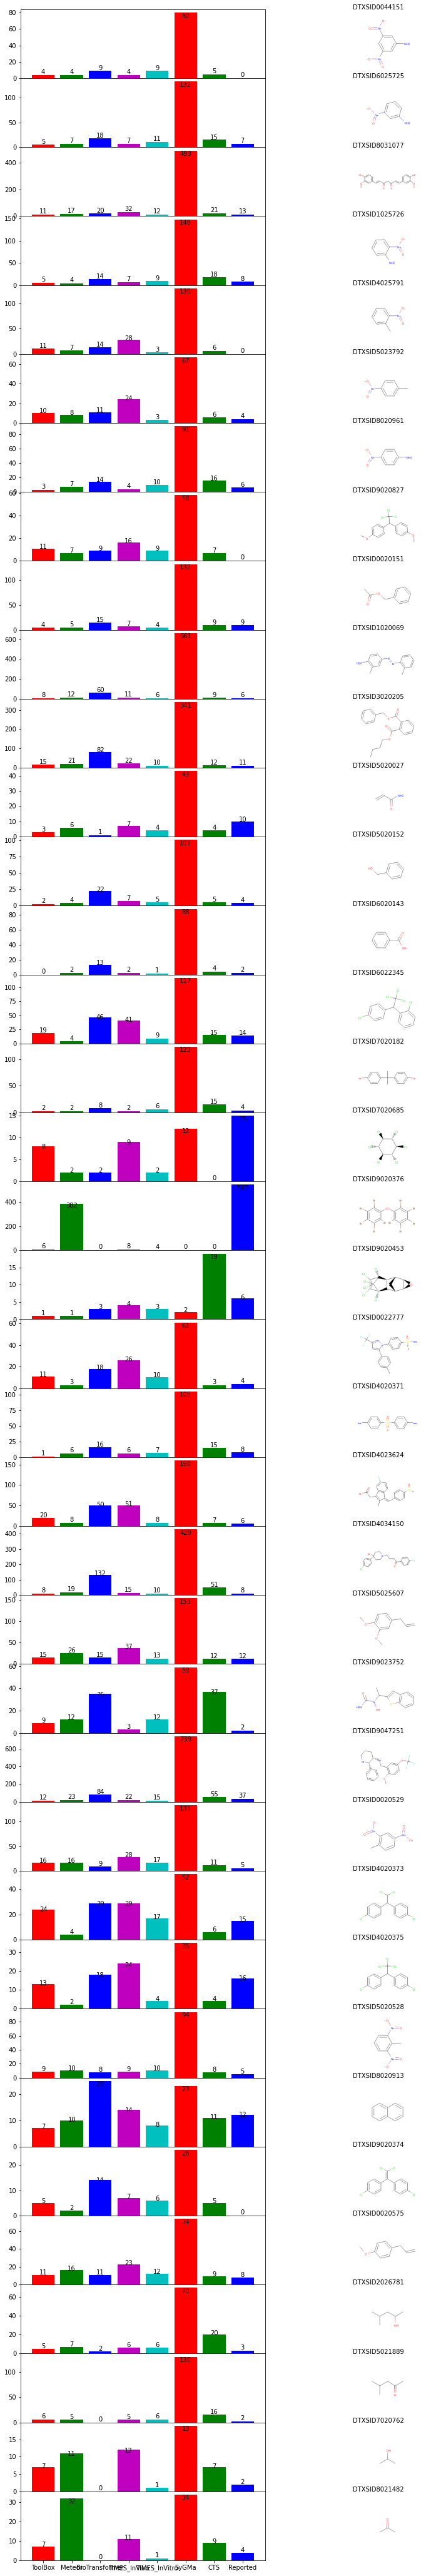

In [61]:
#Generates bargraphs for each parent compound that returns the total metabolites generated by each prediction software accompanied by
#a png of each starting DTXSID

#autolabel function was generated by matplotlib, and generates the total counts for each bar graph at the top of each graph

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """
    
    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        axs[x,0].text(rect.get_x() + rect.get_width()*offset[xpos], 0.9*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')
        


fig, axs = plt.subplots(metab_Comp.shape[0],2, gridspec_kw = {'hspace':0,'wspace':0},figsize = (14, 75))
colors = ['r','g','b','m','c']
image_List = [Chem.Draw.MolToImage(Chem.MolFromSmiles(x)) for x in DSSToxList['SMILES']]
for x in range(metab_Comp.shape[0]):
    rect1 =  axs[x,0].bar(modelList2, metab_Comp.loc[x, modelList2], color = colors)
    autolabel(rect1)
    axs[x,1].imshow(image_List[x])
    axs[x,1].axis('off')
    axs[x,1].annotate(metab_Comp.loc[x, 'DTXSID'], xy = (0.0,0.3))


## Summarized Data and Performance Evaluation <a class="anchor" id="third-bullet"></a>

In [81]:
# Generate a dataframe (model_Comp) that compares the coverage of metabolites between the prediction software and the reported metabolites
#   To generate the table, the software columns are taken from the the aggreagate dataframe and the total and unique
#   metabolites are generates. The total is derived by taking the sum of each software's prediction column and the unqiue
#   is derived by summing each row, which is appended to the matchComp dataframe and titled 'Match_Count'. Each row of 
#   the prediction columns are compared to the 'Match_Count' and unique predictions are counted if the prediction column
#   and Match_Count are equal to 1.

matchComp = agg_Data[modelList2]

#Generate column that sums the number of predictions for each row
matchComp['Match_Count']= matchComp.apply(lambda x: sum(x), axis = 1)

#Generate new dataframe that summarizes the total and unique counts, and compares coverage between models
model_Comp = pd.DataFrame(data = None, columns=['Model','Total','Unique'] + modelList2)
model_Comp.loc[:,'Model'] = [model for model in modelList2]

#Sum the predictions of each software column and assign them to the 'Total' column of the comparison dataframe
total_Counts = [totals for totals in matchComp[modelList2].sum(axis=0)]
model_Comp.loc[:,'Total'] = total_Counts

#Sum unique predictions of each software by taking predictions in the software column (matchComp[match]==1.0) and ensuring that
#these values are the only predictions for that compound (matchComp['Match_Count']==1.0)
uniqueCounts = [matchComp[match][(matchComp[match]==1.0)&(matchComp['Match_Count']==1.0)].sum() for match in modelList2]
model_Comp.loc[:,'Unique'] = uniqueCounts

#For each software column in the comparison dataframe, sum the total number of overlapping predictions between the softwares
for model in modelList2:
    model_Comp.loc[:,model] = [(matchComp[model][(matchComp[model]==1.0)&(matchComp[match] == 1.0)].sum()) for match in modelList2]
    
model_Comp

/home/grace/anaconda3/envs/chemclone/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Model,Total,Unique,ToolBox,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Reported
0,ToolBox,314.0,0.0,314.0,108.0,63.0,232.0,198.0,149.0,129.0,67.0
1,Meteor,714.0,418.0,108.0,714.0,75.0,153.0,98.0,240.0,94.0,62.0
2,BioTransformer,827.0,544.0,63.0,75.0,827.0,62.0,68.0,225.0,81.0,39.0
3,TIMES_InVivo,570.0,132.0,232.0,153.0,62.0,570.0,158.0,295.0,99.0,68.0
4,TIMES_InVitro,283.0,23.0,198.0,98.0,68.0,158.0,283.0,162.0,109.0,62.0
5,SyGMa,5215.0,4578.0,149.0,240.0,225.0,295.0,162.0,5215.0,153.0,67.0
6,CTS,472.0,250.0,129.0,94.0,81.0,99.0,109.0,153.0,472.0,44.0
7,Reported,811.0,697.0,67.0,62.0,39.0,68.0,62.0,67.0,44.0,811.0


In [83]:
model_Comp.to_csv(interim_dat_dir+'Model_Comp.csv')

In [116]:
#Convert the model columns from total overlapping counts to %coverage between each model.
#% coverage takes the total overlapping predictions for Model1 and Model2 divided by the total predictions of Model2. The resulting value states that Model1
# covers x% of the predictions generated by Model2. In this caluclating, Model1 are the models in Column 1 and Model2 are the models between Columns 4-8
# (e.g., metabolites generated by Meteor (Col 1, Row 2) cover ~38.96% of the metabolites generated by ToolBox, ~6.78% of the metabolites generated by 
# BioTransformer, ~25.75% of the metabolites from TIMES_InVivo, and ~37.55% of metabolites generated by TIMES_InVitro)

for model in modelList2:
    model_Comp.loc[:,model] = [round((matchComp[model][(matchComp[model]==1.0)&(matchComp[match] == 1.0)].sum()*100/model_Comp['Total'][modelList2.index(model)]),2) for match in modelList2]

avg_coverage = [round((model_Comp.loc[x,modelList2].sum()-100)/(len(modelList2)-1),2) for x in range(model_Comp.shape[0])]
model_Comp['Avg. Coverage'] = avg_coverage

#Calc performance metrics
precisionList = [calcPrecision(agg_Data, x) for x in modelList2]
sensitivityList = [calcSensitivity(agg_Data, x) for x in modelList2]
model_Comp['Precision'] = precisionList
model_Comp['Sensitivity'] = sensitivityList


model_Comp

,Model,Total,Unique,ToolBox,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Reported,Avg. Coverage,Precision,Sensitivity
0,ToolBox,314.0,0.0,100.00,15.13,7.62,40.70,69.96,2.86,27.33,8.26,24.55,0.213,0.275
1,Meteor,714.0,418.0,34.39,100.00,9.07,26.84,34.63,4.60,19.92,7.64,19.58,0.087,0.225
2,BioTransformer,827.0,544.0,20.06,10.50,100.00,10.88,24.03,4.31,17.16,4.81,13.11,0.047,0.150
3,TIMES_InVivo,570.0,132.0,73.89,21.43,7.50,100.00,55.83,5.66,20.97,8.38,27.67,0.119,0.283
4,TIMES_InVitro,283.0,23.0,63.06,13.73,8.22,27.72,100.00,3.11,23.09,7.64,20.94,0.219,0.254
5,SyGMa,5215.0,4578.0,47.45,33.61,27.21,51.75,57.24,100.00,32.42,8.26,36.85,0.013,0.279
6,CTS,472.0,250.0,41.08,13.17,9.79,17.37,38.52,2.93,100.00,5.43,18.33,0.093,0.179
7,Reported,811.0,697.0,21.34,8.68,4.72,11.93,21.91,1.28,9.32,100.00,11.31,1.000,1.012


In [117]:
combinedPrecision = calcPrecision(agg_Data, modelList)
combinedSensitivity = calcSensitivity(agg_Data, modelList)
(combinedPrecision, combinedSensitivity)


(0.108, 1.012)

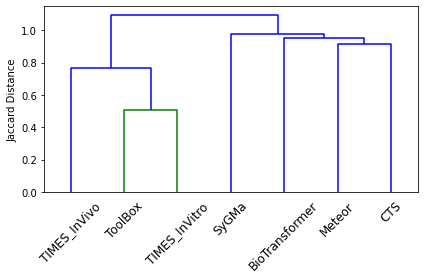

In [120]:
#Compare Similarity of predictions

model_fingerprint_DF = agg_Data.loc[:,['ToolBox', 'Meteor','BioTransformer','TIMES_InVivo','TIMES_InVitro','SyGMa', 'CTS']].transpose()
model_dist_vector = pdist(model_fingerprint_DF, 'jaccard')
cluster = hc.linkage(model_dist_vector, method = 'ward')

plot = hc.dendrogram(cluster, labels = ['ToolBox', 'Meteor','BioTransformer','TIMES_InVivo','TIMES_InVitro','SyGMa', 'CTS'], leaf_rotation = 45)
plt.ylabel('Jaccard Distance')
plt.tight_layout()
plt.savefig(figures_dir+'similarity.png', tight_layout = True, transparent = True)

In [130]:
model_fingerprint_DF

,0,1,2,3,4,5,6,7,8,9,...,7511,7512,7513,7514,7515,7516,7517,7518,7519,7520
ToolBox,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Meteor,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BioTransformer,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TIMES_InVivo,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TIMES_InVitro,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SyGMa,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CTS,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
D_met = pd.DataFrame(squareform(model_dist_vector), columns = model_fingerprint_DF.index, index = model_fingerprint_DF.index)

In [135]:
S_met = 1 - D_met

In [137]:
S_met
Smet = S_met.where(np.tril(np.ones(S_met.shape)).astype(np.bool))

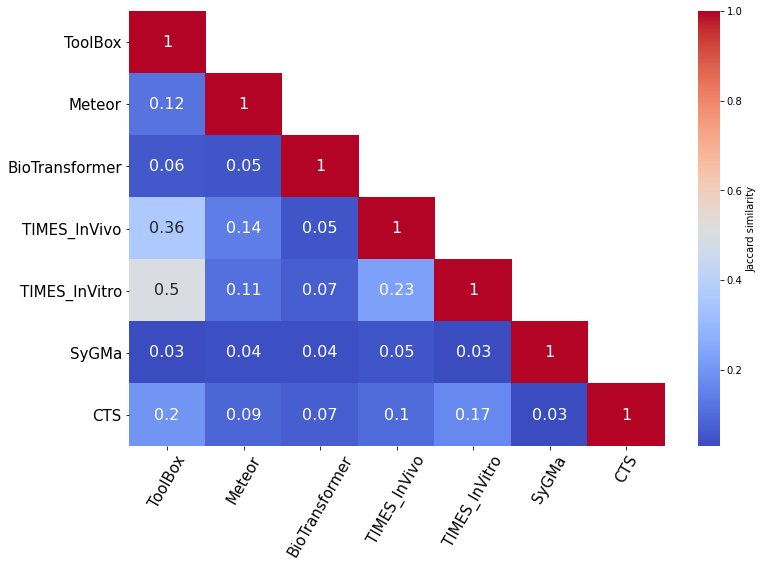

In [142]:
plt.figure(figsize=(12, 8))
sns.heatmap(Smet.round(2), cmap = 'coolwarm',annot=True, cbar_kws={'label': 'Jaccard similarity'}, annot_kws={"size": 16})
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15, rotation = 60)
plt.savefig(figures_dir+'Similarity_mx.png', bbox_inches='tight');

## Chemical Groupings <a class="anchor" id="fourth-bullet"></a>

Morgans FP Grouping: radius = 2, bits = 2048

Text(0, 0.5, 'Jaccard Distance')

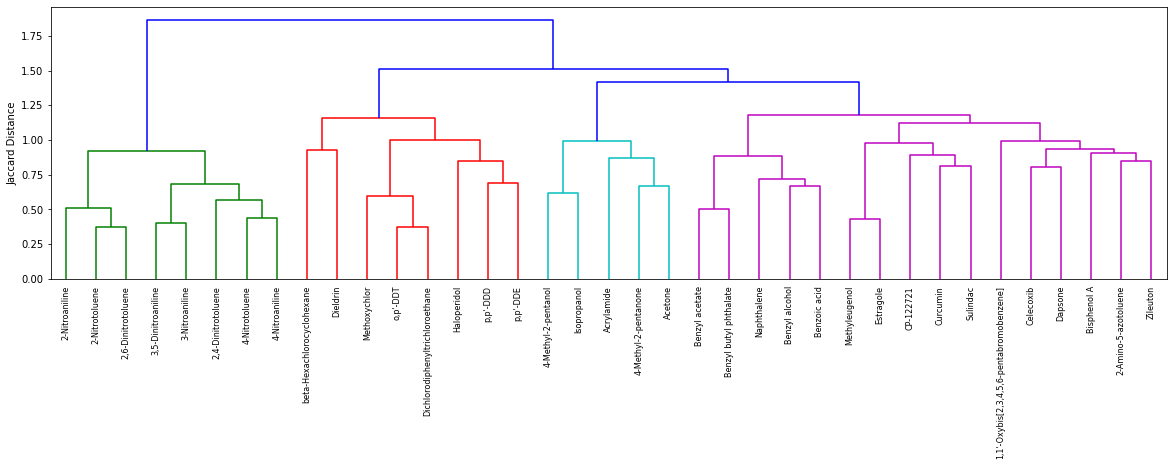

In [143]:
##Generate Heirarchal clustering for parents using morgan fingerprints in RDKit
parentMols = [Chem.MolFromSmiles(x) for x in DSSToxList['QSAR_READY_SMILES']]
parentFPS = np.array([np.array(AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=2048)) for mol in parentMols])
parentDist = pdist(parentFPS, metric = 'jaccard')
parentGroup = hc.linkage(parentDist, method = 'ward')
parentLabel = DSSToxList['PREFERRED_NAME']
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
plot = hc.dendrogram(parentGroup, labels = parentLabel.to_list(), leaf_rotation = 90)#, labels = ['ToolBox', 'Meteor','BioTransformer','TIMES_InVivo','TIMES_InVitro','SyGMa'], leaf_rotation = 45)
plt.ylabel('Jaccard Distance')

In [144]:
groups = 5
groupCut = hc.cut_tree(parentGroup, groups)
par_Group = {'DTXSID': [None] * groups, 'MOL':[None] * groups}
for idx in range(len(groupCut)):
    groupValue = groupCut[idx, 0]
    if par_Group['DTXSID'][groupValue] is None:
        par_Group['DTXSID'][groupValue] = [DSSToxList.loc[idx, 'DTXSID']]
        par_Group['MOL'][groupValue] = [Chem.MolFromSmiles(DSSToxList.loc[idx, 'QSAR_READY_SMILES'])]
        
    else:
        par_Group['DTXSID'][groupValue] += [DSSToxList.loc[idx, 'DTXSID']]        
        par_Group['MOL'][groupValue] += [Chem.MolFromSmiles(DSSToxList.loc[idx, 'QSAR_READY_SMILES'])]

Group:  0


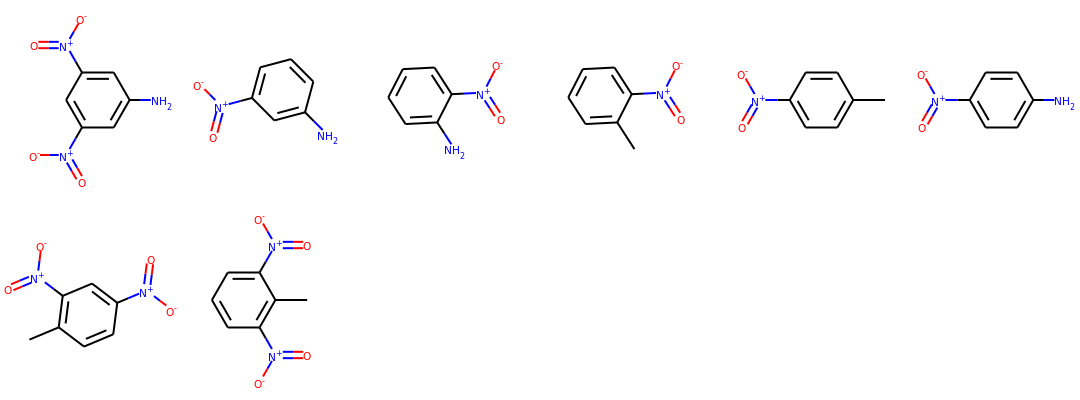

Group:  1


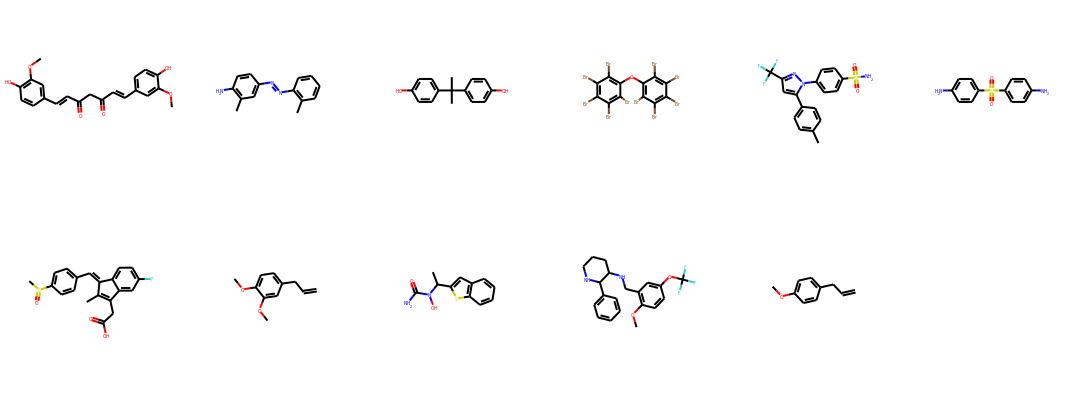

Group:  2


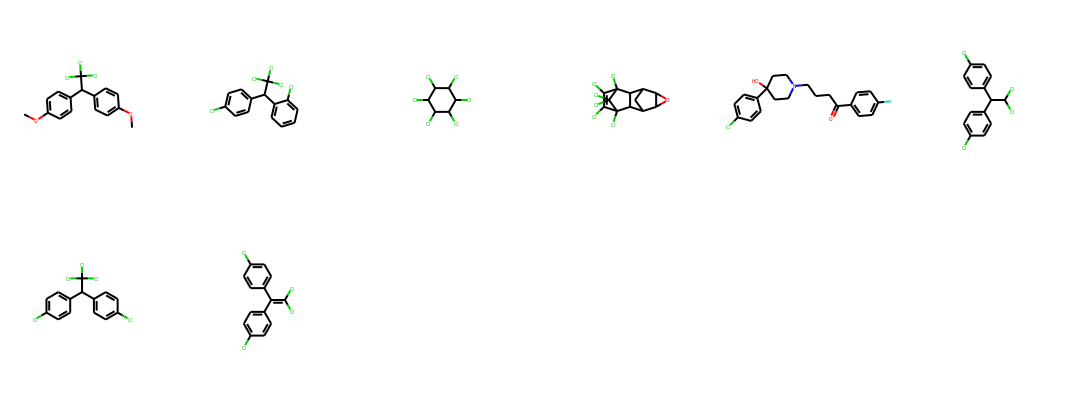

Group:  3


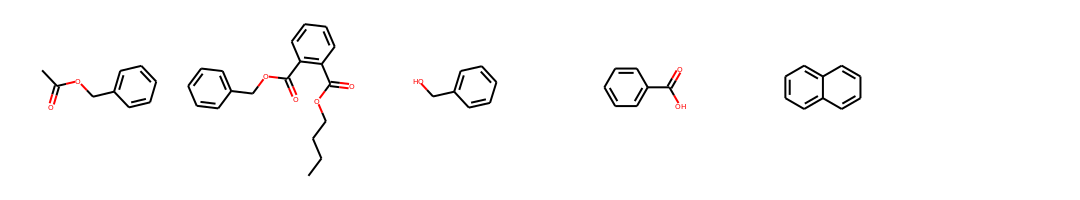

Group:  4


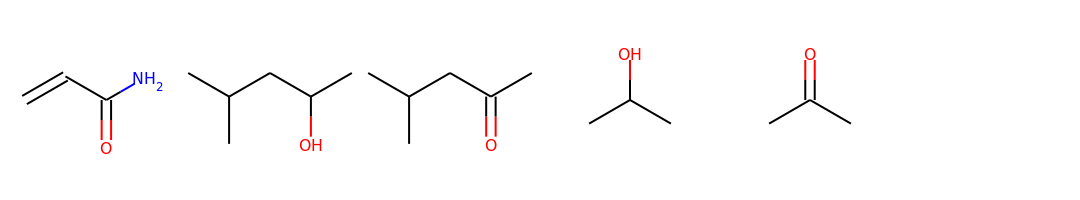

In [145]:
num = 0
for groups in par_Group['MOL']:
    print('Group: ', num)
    display(Draw.MolsToGridImage(groups, molsPerRow=6, subImgSize=(180, 200)))
    num+=1

#### Missing classyFire_ExpoCast.csv...

In [148]:
classyFireDF = pd.read_csv(raw_dat_dir+'classyFire_ExpoCast.csv')
DTXSIDlist = DSSToxList['INPUT']
matchDTXSID = []
for compoundID in classyFireDF['CompoundID']:
    idx = int(compoundID.split('-')[1])-1
    matchDTXSID += [DTXSIDlist[idx]]

classyFireDF['DTXSID'] = matchDTXSID

In [149]:
classyFireDF.head(5)

,CompoundID,ChemOntID,ParentName,DTXSID
0,Q5233679-1,CHEMONTID:0003968,Dinitroanilines,DTXSID0044151
1,Q5233679-1,CHEMONTID:0000036,Nitrobenzenes,DTXSID0044151
2,Q5233679-1,CHEMONTID:0004612,Nitroaromatic compounds,DTXSID0044151
3,Q5233679-1,CHEMONTID:0003633,"Propargyl-type 1,3-dipolar organic compounds",DTXSID0044151
4,Q5233679-1,CHEMONTID:0001508,Organic oxoazanium compounds,DTXSID0044151


In [150]:
fpCatalog = pd.Series(list(set(classyFireDF['ParentName'])))
fpCatalog

0             Dinitrotoluenes
1             Dinitroanilines
2              Trialkylamines
3             Organofluorides
4                      Oxanes
                ...          
103    Carboxylic acid esters
104          Aminopiperidines
105         Phenylpiperidines
106          Diphenylmethanes
107                  Sulfones
Length: 108, dtype: object

In [151]:
fpDF = pd.DataFrame()
x = 0
for DTXSID in DTXSIDlist:
    fpList = []
    DTXSIDfilter = classyFireDF['DTXSID'] == DTXSID
    for fp in fpCatalog:
        fpList += [int(fp in classyFireDF.loc[DTXSIDfilter,'ParentName'].values)]
    fpDF[x] = fpList
    x+=1
fpMatrix = fpDF.T.values

Text(0, 0.5, 'Jaccard Distance')

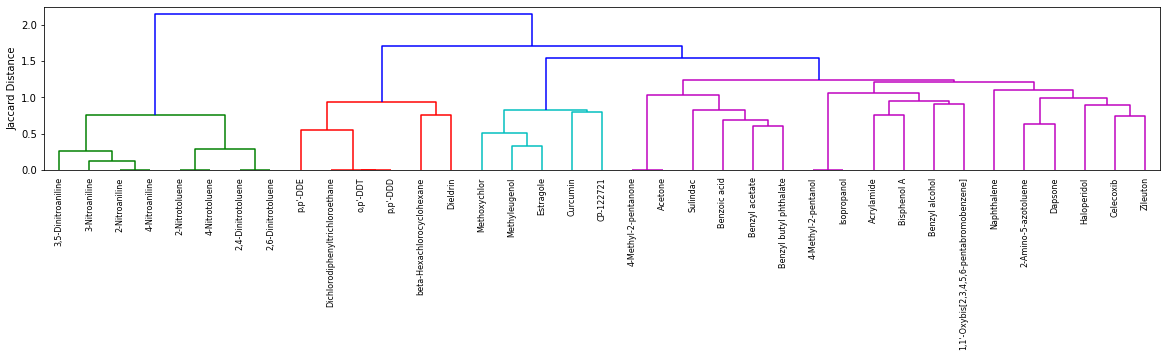

In [152]:
fpDist = pdist(fpMatrix, metric = 'jaccard')
parentGroup = hc.linkage(fpDist, method = 'ward')
parentLabel = DSSToxList['PREFERRED_NAME']
fig, axes = plt.subplots(1, 1, figsize=(20, 3))
plot = hc.dendrogram(parentGroup, labels = parentLabel.to_list(), leaf_rotation = 90)
plt.ylabel('Jaccard Distance')

Group:  0


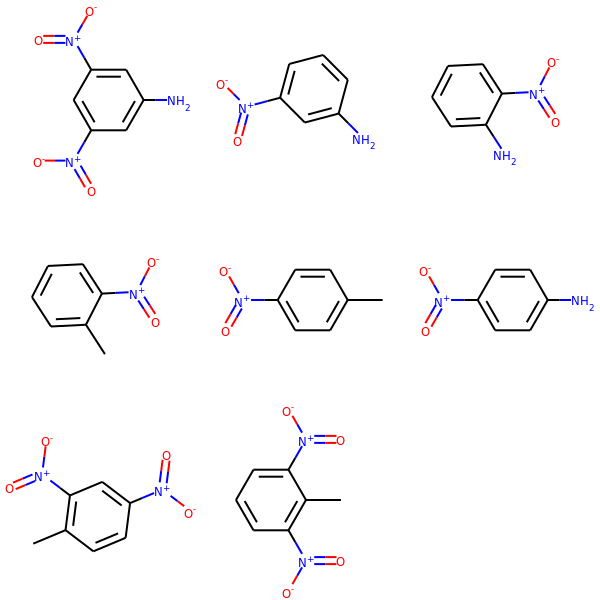

Group:  1


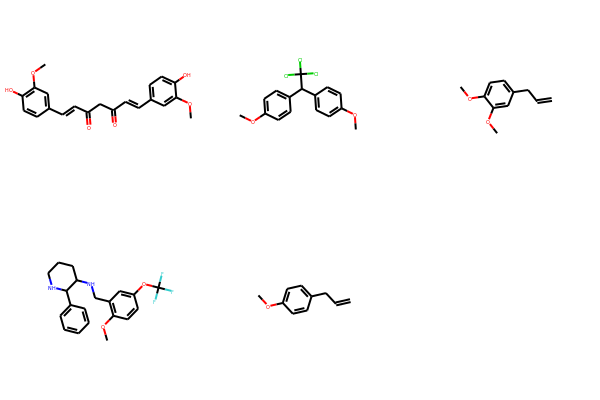

Group:  2


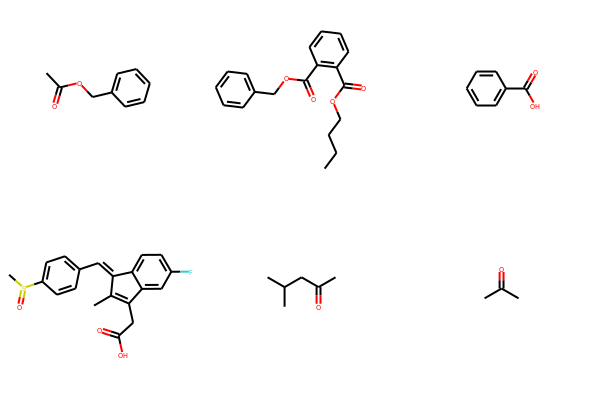

Group:  3


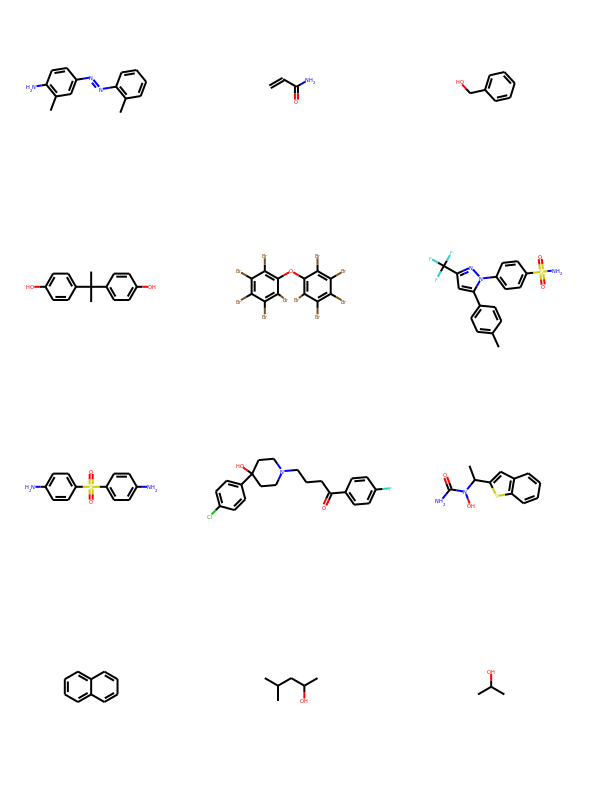

Group:  4


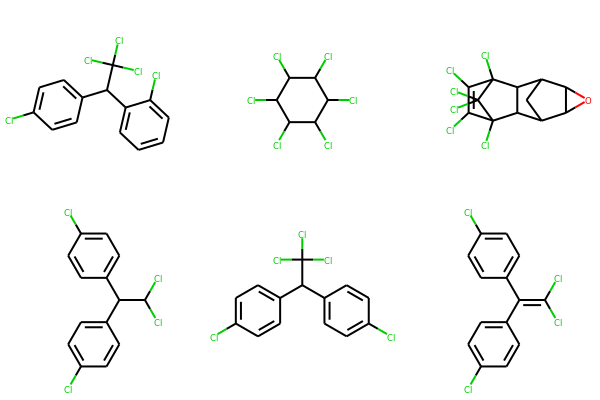

In [154]:
groups = 5
testCut = hc.cut_tree(parentGroup, groups)
cf_Group = {'DTXSID' : [None] * groups, 'MOL':[None] * groups}
for idx in range(len(testCut)):
    groupValue = testCut[idx, 0]
    if cf_Group['DTXSID'][groupValue] is None:
        cf_Group['DTXSID'][groupValue] = [DSSToxList.loc[idx, 'DTXSID']]
        cf_Group['MOL'][groupValue] = [Chem.MolFromSmiles(DSSToxList.loc[idx, 'QSAR_READY_SMILES'])]
        
    else:
        cf_Group['DTXSID'][groupValue] += [DSSToxList.loc[idx, 'DTXSID']]        
        cf_Group['MOL'][groupValue] += [Chem.MolFromSmiles(DSSToxList.loc[idx, 'QSAR_READY_SMILES'])]

num = 0
for groups in cf_Group['MOL']:
    print('Group: ', num)
    display(Draw.MolsToGridImage(groups, molsPerRow=3, subImgSize=(200, 200)))
    num+=1


## Performance Per Grouping <a class="anchor" id="fifth-bullet"></a>

In [199]:
cf_Group['DTXSID']

In [204]:
performanceComp = agg_Data[agg_Data['DTXSID'].isin(cf_Group['DTXSID'][0])]

In [207]:
performanceComp
precisionList = [calcPrecision(performanceComp, x) for x in modelList]
print(precisionList)
sensitivityList = [calcSensitivity(performanceComp, x) for x in modelList]
print(sensitivityList)

[0.19, 0.143, 0.062, 0.099, 0.167, 0.018, 0.094]
[0.343, 0.257, 0.171, 0.314, 0.343, 0.457, 0.229]


In [208]:
matchComp = agg_Data[agg_Data['DTXSID'].isin(cf_Group['DTXSID'][0])][modelList]
matchComp['Match_Count']= matchComp.apply(lambda x: sum(x), axis = 1)
#print(matchComp)
model_Comp = pd.DataFrame(data = None, columns=['Model','Total','Unique']+modelList)
model_Comp.loc[:,'Model'] = [model for model in modelList]

total_Counts = [totals for totals in matchComp[modelList].sum(axis=0)]
model_Comp.loc[:,'Total'] = total_Counts
#print(model_Comp)
uniqueCounts = [matchComp[match][(matchComp[match]==1.0)&(matchComp['Match_Count']==1.0)].sum() for match in modelList]
model_Comp.loc[:,'Unique'] = uniqueCounts

In [209]:
model_Comp['Precision'] = precisionList
model_Comp['Sensitivity'] = sensitivityList 

for model in modelList:
    model_Comp.loc[:,model] = [(matchComp[model][(matchComp[model]==1.0)&(matchComp[match] == 1.0)].sum()) for match in modelList]

for model in modelList:
    model_Comp.loc[:,model] = [round((matchComp[model][(matchComp[model]==1.0)&(matchComp[match] == 1.0)].sum()*100 / model_Comp['Total'][modelList.index(model)]),2) for match in modelList]    

avg_coverage = [round((model_Comp.loc[x, [match for match in modelList if match != modelList[x]]].sum())/(len(modelList)-1), 2) for x in range(model_Comp.shape[0])]

model_Comp['Avg. Coverage'] = avg_coverage
model_Comp

,Model,Total,Unique,ToolBox,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Precision,Sensitivity,Avg. Coverage
0,ToolBox,63.0,0.0,100.00,46.03,14.43,40.54,56.94,5.49,44.71,0.190,0.343,34.69
1,Meteor,63.0,0.0,46.03,100.00,18.56,30.63,37.50,6.74,31.76,0.143,0.257,28.54
2,BioTransformer,97.0,30.0,22.22,28.57,100.00,13.51,25.00,6.97,9.41,0.062,0.171,17.61
3,TIMES_InVivo,111.0,12.0,71.43,53.97,15.46,100.00,38.89,9.94,36.47,0.099,0.314,37.69
4,TIMES_InVitro,72.0,13.0,65.08,42.86,18.56,25.23,100.00,5.83,35.29,0.167,0.343,32.14
5,SyGMa,875.0,702.0,76.19,93.65,62.89,78.38,70.83,100.00,37.65,0.018,0.457,69.93
6,CTS,85.0,42.0,60.32,42.86,8.25,27.93,41.67,3.66,100.00,0.094,0.229,30.78


In [211]:
group = cf_Group['DTXSID'][1]

performanceComp = agg_Data[agg_Data['DTXSID'].isin(group)]

matchComp = agg_Data[agg_Data['DTXSID'].isin(group)][modelList]
matchComp['Match_Count']= matchComp.apply(lambda x: sum(x), axis = 1)

model_Comp = pd.DataFrame(data = None, columns=['Model','Total','Unique']+modelList)
model_Comp.loc[:,'Model'] = [model for model in modelList]

total_Counts = [totals for totals in matchComp[modelList].sum(axis=0)]
model_Comp.loc[:,'Total'] = total_Counts

uniqueCounts = [matchComp[match][(matchComp[match]==1.0)&(matchComp['Match_Count']==1.0)].sum() for match in modelList]
model_Comp.loc[:,'Unique'] = uniqueCounts

precisionList = [calcPrecision(performanceComp, x) for x in modelList]
sensitivityList = [calcSensitivity(performanceComp, x) for x in modelList]
model_Comp['Precision'] = precisionList
model_Comp['Sensitivity'] = sensitivityList 

for model in modelList:
    model_Comp.loc[:,model] = [(matchComp[model][(matchComp[model]==1.0)&(matchComp[match] == 1.0)].sum()) for match in modelList]

for model in modelList:
    model_Comp.loc[:,model] = [round((matchComp[model][(matchComp[model]==1.0)&(matchComp[match] == 1.0)].sum()*100 / model_Comp['Total'][modelList.index(model)]),2) for match in modelList]    

avg_coverage = [round((model_Comp.loc[x, [match for match in modelList if match != modelList[x]]].sum())/(len(modelList)-1), 2) for x in range(model_Comp.shape[0])]

model_Comp['Avg. Coverage'] = avg_coverage
model_Comp

,Model,Total,Unique,ToolBox,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Precision,Sensitivity,Avg. Coverage
0,ToolBox,60.0,0.0,100.00,28.09,11.51,36.15,72.13,2.18,32.69,0.183,0.216,30.46
1,Meteor,89.0,18.0,41.67,100.00,15.11,26.15,36.07,4.09,22.12,0.101,0.176,24.20
2,BioTransformer,139.0,109.0,26.67,23.60,100.00,10.00,22.95,1.25,19.23,0.094,0.235,17.28
3,TIMES_InVivo,130.0,29.0,78.33,38.20,9.35,100.00,65.57,5.34,25.96,0.069,0.176,37.12
4,TIMES_InVitro,61.0,4.0,73.33,24.72,10.07,30.77,100.00,2.44,25.96,0.164,0.196,27.88
5,SyGMa,1517.0,1387.0,55.00,69.66,13.67,62.31,60.66,100.00,34.62,0.007,0.196,49.32
6,CTS,104.0,49.0,56.67,25.84,14.39,20.77,44.26,2.37,100.00,0.077,0.157,27.38


In [213]:
group = cf_Group['DTXSID'][2]

performanceComp = agg_Data[agg_Data['DTXSID'].isin(group)]

matchComp = agg_Data[agg_Data['DTXSID'].isin(group)][modelList]
matchComp['Match_Count']= matchComp.apply(lambda x: sum(x), axis = 1)

model_Comp = pd.DataFrame(data = None, columns=['Model','Total','Unique']+modelList)
model_Comp.loc[:,'Model'] = [model for model in modelList]

total_Counts = [totals for totals in matchComp[modelList].sum(axis=0)]
model_Comp.loc[:,'Total'] = total_Counts

uniqueCounts = [matchComp[match][(matchComp[match]==1.0)&(matchComp['Match_Count']==1.0)].sum() for match in modelList]
model_Comp.loc[:,'Unique'] = uniqueCounts

precisionList = [calcPrecision(performanceComp, x) for x in modelList]
sensitivityList = [calcSensitivity(performanceComp, x) for x in modelList]
model_Comp['Precision'] = precisionList
model_Comp['Sensitivity'] = sensitivityList 

for model in modelList:
    model_Comp.loc[:,model] = [(matchComp[model][(matchComp[model]==1.0)&(matchComp[match] == 1.0)].sum()) for match in modelList]

for model in modelList:
    model_Comp.loc[:,model] = [round((matchComp[model][(matchComp[model]==1.0)&(matchComp[match] == 1.0)].sum()*100 / model_Comp['Total'][modelList.index(model)]),2) for match in modelList]    

avg_coverage = [round((model_Comp.loc[x, [match for match in modelList if match != modelList[x]]].sum())/(len(modelList)-1), 2) for x in range(model_Comp.shape[0])]

model_Comp['Avg. Coverage'] = avg_coverage
model_Comp

,Model,Total,Unique,ToolBox,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Precision,Sensitivity,Avg. Coverage
0,ToolBox,52.0,0.0,100.00,28.77,0.00,45.92,86.67,3.39,35.09,0.269,0.412,33.31
1,Meteor,73.0,20.0,40.38,100.00,1.25,33.67,53.33,5.65,35.09,0.219,0.471,28.23
2,BioTransformer,160.0,127.0,0.00,2.74,100.00,2.04,3.33,3.73,3.51,0.013,0.059,2.56
3,TIMES_InVivo,98.0,19.0,86.54,45.21,1.25,100.00,76.67,6.78,33.33,0.163,0.471,41.63
4,TIMES_InVitro,30.0,0.0,50.00,21.92,0.62,23.47,100.00,2.26,31.58,0.400,0.353,21.64
5,SyGMa,885.0,766.0,57.69,68.49,20.62,61.22,66.67,100.00,49.12,0.018,0.471,53.97
6,CTS,57.0,23.0,38.46,27.40,1.25,19.39,60.00,3.16,100.00,0.246,0.412,24.94


In [214]:
group = cf_Group['DTXSID'][3]

performanceComp = agg_Data[agg_Data['DTXSID'].isin(group)]

matchComp = agg_Data[agg_Data['DTXSID'].isin(group)][modelList]
matchComp['Match_Count']= matchComp.apply(lambda x: sum(x), axis = 1)

model_Comp = pd.DataFrame(data = None, columns=['Model','Total','Unique']+modelList)
model_Comp.loc[:,'Model'] = [model for model in modelList]

total_Counts = [totals for totals in matchComp[modelList].sum(axis=0)]
model_Comp.loc[:,'Total'] = total_Counts

uniqueCounts = [matchComp[match][(matchComp[match]==1.0)&(matchComp['Match_Count']==1.0)].sum() for match in modelList]
model_Comp.loc[:,'Unique'] = uniqueCounts

precisionList = [calcPrecision(performanceComp, x) for x in modelList]
sensitivityList = [calcSensitivity(performanceComp, x) for x in modelList]
model_Comp['Precision'] = precisionList
model_Comp['Sensitivity'] = sensitivityList 

for model in modelList:
    model_Comp.loc[:,model] = [(matchComp[model][(matchComp[model]==1.0)&(matchComp[match] == 1.0)].sum()) for match in modelList]

for model in modelList:
    model_Comp.loc[:,model] = [round((matchComp[model][(matchComp[model]==1.0)&(matchComp[match] == 1.0)].sum()*100 / model_Comp['Total'][modelList.index(model)]),2) for match in modelList]    

avg_coverage = [round((model_Comp.loc[x, [match for match in modelList if match != modelList[x]]].sum())/(len(modelList)-1), 2) for x in range(model_Comp.shape[0])]

model_Comp['Avg. Coverage'] = avg_coverage
model_Comp

,Model,Total,Unique,ToolBox,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Precision,Sensitivity,Avg. Coverage
0,ToolBox,69.0,1.0,100.00,6.12,6.58,34.19,63.29,1.59,19.77,0.246,0.235,21.92
1,Meteor,474.0,390.0,42.03,100.00,9.09,38.46,36.71,3.42,12.99,0.055,0.265,23.78
2,BioTransformer,319.0,222.0,30.43,6.12,100.00,21.37,30.38,4.31,20.90,0.053,0.221,18.92
3,TIMES_InVivo,117.0,25.0,57.97,9.49,7.84,100.00,51.90,3.19,11.30,0.162,0.279,23.62
4,TIMES_InVitro,79.0,6.0,72.46,6.12,7.52,35.04,100.00,2.48,18.08,0.253,0.279,23.62
5,SyGMa,1694.0,1538.0,39.13,12.24,22.88,46.15,53.16,100.00,27.12,0.012,0.309,33.45
6,CTS,177.0,104.0,50.72,4.85,11.60,17.09,40.51,2.83,100.00,0.079,0.191,21.27


In [215]:
group = cf_Group['DTXSID'][4]

performanceComp = agg_Data[agg_Data['DTXSID'].isin(group)]

matchComp = agg_Data[agg_Data['DTXSID'].isin(group)][modelList]
matchComp['Match_Count']= matchComp.apply(lambda x: sum(x), axis = 1)

model_Comp = pd.DataFrame(data = None, columns=['Model','Total','Unique']+modelList)
model_Comp.loc[:,'Model'] = [model for model in modelList]

total_Counts = [totals for totals in matchComp[modelList].sum(axis=0)]
model_Comp.loc[:,'Total'] = total_Counts

uniqueCounts = [matchComp[match][(matchComp[match]==1.0)&(matchComp['Match_Count']==1.0)].sum() for match in modelList]
model_Comp.loc[:,'Unique'] = uniqueCounts

precisionList = [calcPrecision(performanceComp, x) for x in modelList]
sensitivityList = [calcSensitivity(performanceComp, x) for x in modelList]
model_Comp['Precision'] = precisionList
model_Comp['Sensitivity'] = sensitivityList 

for model in modelList:
    model_Comp.loc[:,model] = [(matchComp[model][(matchComp[model]==1.0)&(matchComp[match] == 1.0)].sum()) for match in modelList]

for model in modelList:
    model_Comp.loc[:,model] = [round((matchComp[model][(matchComp[model]==1.0)&(matchComp[match] == 1.0)].sum()*100 / model_Comp['Total'][modelList.index(model)]),2) for match in modelList]    

avg_coverage = [round((model_Comp.loc[x, [match for match in modelList if match != modelList[x]]].sum())/(len(modelList)-1), 2) for x in range(model_Comp.shape[0])]

model_Comp['Avg. Coverage'] = avg_coverage
model_Comp

,Model,Total,Unique,ToolBox,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Precision,Sensitivity,Avg. Coverage
0,ToolBox,70.0,0.0,100.00,26.67,10.71,48.25,90.24,4.51,4.08,0.186,0.250,30.74
1,Meteor,15.0,2.0,5.71,100.00,4.46,6.14,9.76,4.51,2.04,0.133,0.038,5.44
2,BioTransformer,112.0,64.0,17.14,33.33,100.00,6.14,26.83,15.98,28.57,0.009,0.019,21.33
3,TIMES_InVivo,114.0,49.0,78.57,46.67,6.25,100.00,63.41,5.33,4.08,0.114,0.250,34.05
4,TIMES_InVitro,41.0,0.0,52.86,26.67,9.82,22.81,100.00,4.92,4.08,0.195,0.154,20.19
5,SyGMa,244.0,192.0,15.71,73.33,34.82,11.40,29.27,100.00,18.37,0.016,0.077,30.48
6,CTS,49.0,34.0,2.86,6.67,12.50,1.75,4.88,3.69,100.00,0.000,0.000,5.39
